In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

import cv2
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines, _select_lines,
    group_lines, crop_image_by_points, _straighten_mask)
from src.utils.plotting import display_img
from src.utils.playfield_finder import PlayfieldFinder
import matplotlib.pyplot as plt
import numpy as np
from src.utils.lines import Line
from src.utils.points import Point
from src.utils.intersections import compute_intersections

plt.rcParams['image.cmap'] = 'gray'

In [2]:
pic = read_image_as_numpyimage('/home/polymorvic/development/deep-peep-snooker/pics/pic_07_34_02.png', 'rgb') #     pic_02_07_01.png   pic_05_18_01.png # runda_8/pic_08_08_01.png'
cropped_pic = crop_center(pic)

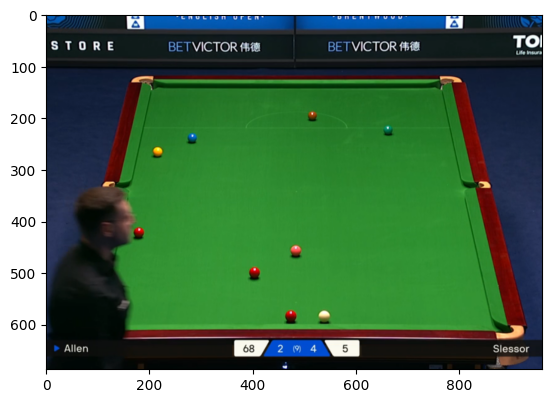

In [3]:
plt.imshow(pic)

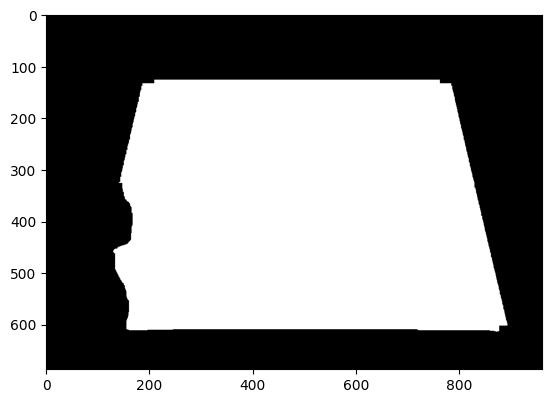

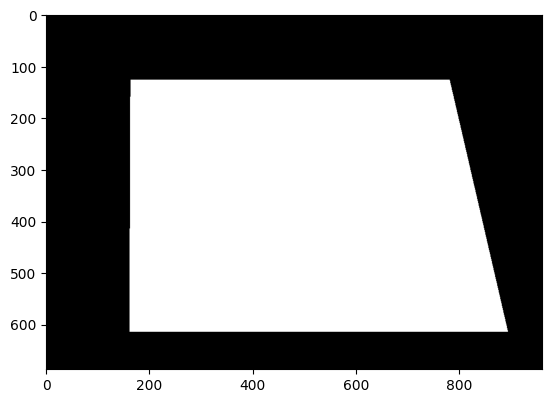

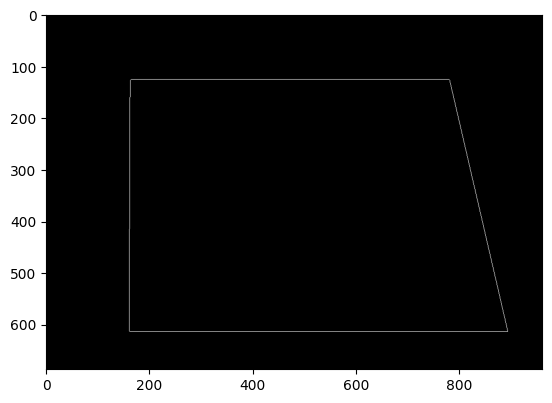

[[[162 614 895 614]]

 [[165 126 781 126]]

 [[782 127 894 610]]

 [[162 415 162 161]]

 [[161 613 161 416]]]
[y = 0.0 * x + 614.0, y = 0.0 * x + 126.0, y = 4.3125 * x + -3245.375, y = None * x + None, y = None * x + None]


TypeError: bad operand type for unary -: 'NoneType'

In [4]:
finder = PlayfieldFinder(pic)

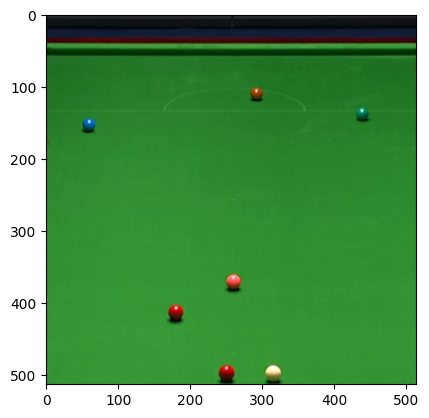

In [5]:
plt.imshow(cropped_pic)

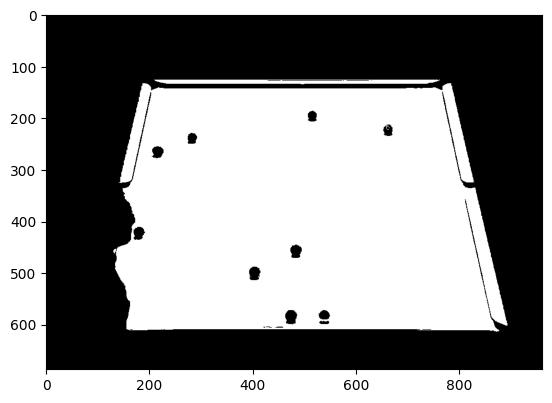

In [6]:
pic_hsv = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)
cropped_pic_hsv = cv2.cvtColor(cropped_pic, cv2.COLOR_RGB2HSV)

dominant_color = pipette_color(cropped_pic_hsv)

h, s, v = dominant_color
h_std = np.std(cropped_pic_hsv[:, :, 0])
s_std = np.std(cropped_pic_hsv[:, :, 1])
v_std = np.std(cropped_pic_hsv[:, :, 2])

h_tolerance = int(h_std * 1.5)
s_tolerance = int(s_std * 1.5)
v_tolerance = int(v_std * 1.5)

lower_bound = np.array([max(0, h - h_tolerance), 
                       max(0, s - s_tolerance), 
                       max(0, v - v_tolerance)])

upper_bound = np.array([min(179, h + h_tolerance), 
                       min(255, s + s_tolerance), 
                       min(255, v + v_tolerance)])

binary_mask = cv2.inRange(pic_hsv, lower_bound, upper_bound)

plt.imshow(binary_mask)
plt.show()

In [7]:
inv_binary_img = cv2.bitwise_not(binary_mask)

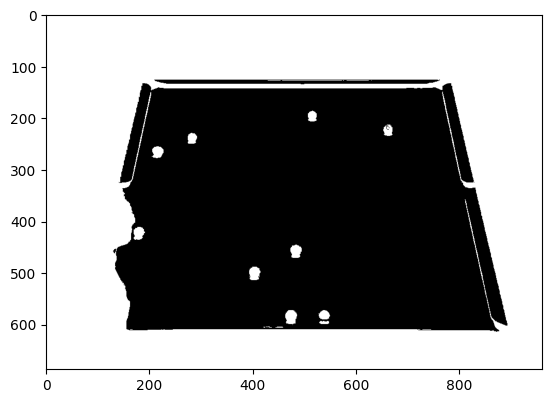

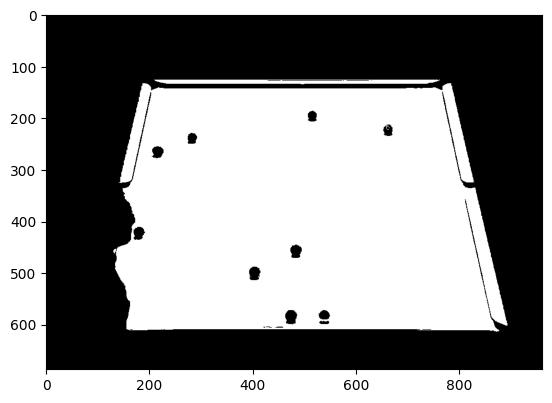

In [8]:
plt.imshow(inv_binary_img)
plt.show()
plt.imshow(binary_mask)

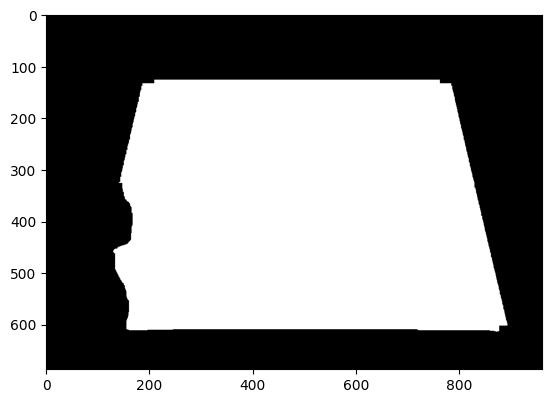

In [9]:
binary_mask_close = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((21, 21), np.uint8))
plt.imshow(binary_mask_close)

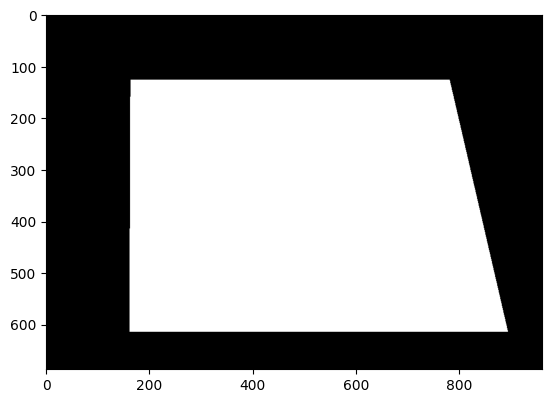

In [10]:
smoothed_binary_mask = _straighten_mask(binary_mask_close)
plt.imshow(smoothed_binary_mask)

In [11]:
edges = cv2.Canny(smoothed_binary_mask, 150, 200)
segments = cv2.HoughLinesP(
    edges, 
    1, 
    np.pi / 180, 
    threshold=100, 
    minLineLength=100, 
    maxLineGap=10
)

lines = _convert_hough_segments_to_lines(segments)
lines = group_lines(lines, thresh_intercept=100)
lines = _select_lines(lines)
intersections = compute_intersections(lines, binary_mask)

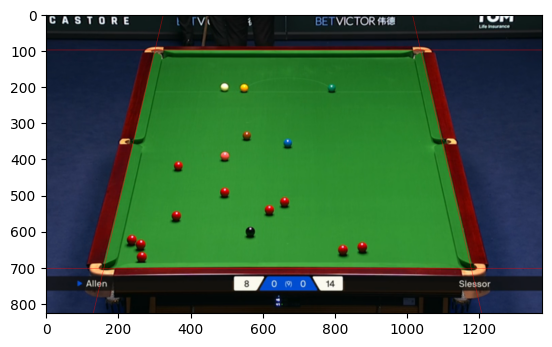

In [12]:
pic_copy = pic.copy()
for line in lines:
    cv2.line(pic_copy, *line.limit_to_img(pic_copy), (255, 0, 0), 1)
display_img(pic_copy)

In [13]:
# intersections = set()
# for group1 in lines:
#     for group2 in lines:
#         intersection = group1.intersection(group2, pic_copy)
#         print(intersection)
#         if intersection is not None:
#             intersections.add(intersection)
            
# intersections = list(intersections)
# intersection_points = np.array([[int(inter.point.x), int(inter.point.y)] for inter in intersections])

intersections = compute_intersections(lines, pic_copy)
intersection_points = np.array([[int(inter.point.x), int(inter.point.y)] for inter in intersections])

In [14]:
intersections

[Point (301, 99) line1: [y = -4.27 * x + 1386.93] line2: [y = 0.00 * x + 99.00],
 Point (1038, 99) line1: [y = 0.00 * x + 99.00] line2: [y = 4.31 * x + -4378.16],
 Point (160, 703) line1: [y = -4.27 * x + 1386.93] line2: [y = 0.00 * x + 703.00],
 Point (1178, 703) line1: [y = 0.00 * x + 703.00] line2: [y = 4.31 * x + -4378.16]]

In [15]:
intersection_points

array([[ 301,   99],
       [1038,   99],
       [ 160,  703],
       [1178,  703]])

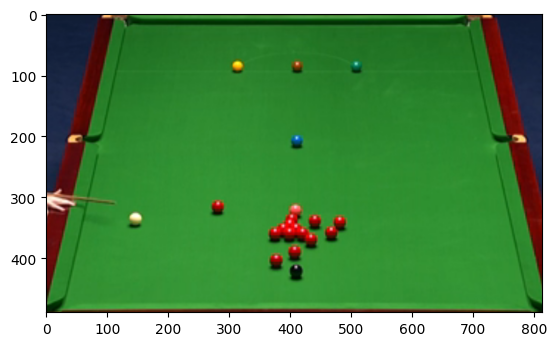

(135, 91)

In [59]:
cropped_by_points, x_start, y_start = crop_image_by_points(pic, intersection_points)
display_img(cropped_by_points)
x_start, y_start 

In [61]:
h, w = cropped_by_points.shape[:2]
roi = cropped_by_points[int(0.95*h):] 

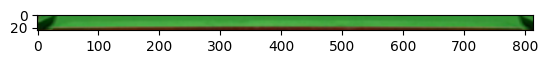

In [62]:
display_img(roi)

In [63]:
hsv_img = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_img)

In [64]:
n_split = 10
breaks = np.linspace(0, roi.width, n_split, dtype=np.int16)
for i in range(1, len(breaks)):
    v_piece = v[:, breaks[i-1]:breaks[i]]


    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # v_piece = clahe.apply(v_piece)
    # v_piece = cv2.bilateralFilter(v_piece, 9, 10, 10)

    # plt.imshow(v_piece)
    # plt.show()

    # egdes = cv2.Canny(v_piece, 5, 15)
    # plt.imshow(egdes)
    # plt.show()
    # segments = cv2.HoughLinesP(egdes, 1, np.pi/180, 25, int(v_piece.shape[1] * 0.6), 20)
    # if segments is None:
    #     print('not found')
    #     continue

    # lines = _convert_hough_segments_to_lines(segments)
    # roi_piece = roi[:, breaks[i-1]:breaks[i]]
    # for line in lines:
    #     pts = line.limit_to_img(roi_piece)
    #     cv2.line(roi_piece, *pts, (255, 0, 0), 1)
    # display_img(roi_piece)
    # line = sorted(lines, key=lambda line: line.intercept)[0]
    # print(line)

In [65]:
egdes = cv2.Canny(v, 10, 50)

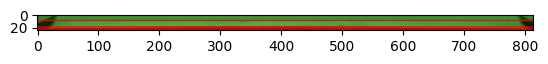

In [66]:
segments = cv2.HoughLinesP(egdes, 1, np.pi/180, 100, 100, 10)
lines = _convert_hough_segments_to_lines(segments)
pic_copy = roi.copy()
for line in lines:
    pts = line.limit_to_img(pic_copy)
    cv2.line(pic_copy, *pts, (255, 0, 0), 1)
display_img(pic_copy)

In [67]:
lines

[y = 0.0 * x + 22.0,
 y = 0.0 * x + 24.0,
 y = 0.0 * x + 19.0,
 y = 0.0 * x + 22.0,
 y = 0.0 * x + 10.0,
 y = 0.0 * x + 9.0,
 y = 0.0 * x + 10.0,
 y = 0.0 * x + 9.0,
 y = 0.0 * x + 21.0,
 y = 0.0 * x + 10.0,
 y = 0.0 * x + 10.0,
 y = 0.0 * x + 9.0,
 y = 0.0 * x + 22.0]